# Final Project: Sustainable Energy Analysis Platform (Part 2) 

*Predicting Future Energy Efficiency and Demand in Clean Energy Transitions Using Machine Learning and Deep Learning Techniques*

> In this notebook contains the final implementation of my data analysis project. I have built predictive models using both Machine Learning and Deep Learning approaches to forecast energy generation from renewable sources such as solar, wind, hydroelectric, and biofuel.

## Author

### *Carlos Vergara Gámez*
Github: https://github.com/PoeMadara

Linkedin: https://www.linkedin.com/in/carlosvergaragamez/

E-mail: carlos.poemadara@gmail.com

## Source

*The dataset utilized for this research was sourced from the following reference:*

> Ritchie, H., Rosado, P., & Roser, M. (2023). *Energy*. Published online at **OurWorldinData.org**. Retrieved from: [https://ourworldindata.org/energy](https://ourworldindata.org/energy) [Online Resource]

*This resource has been invaluable in providing comprehensive data for analyzing energy trends and facilitating informed insights in my research.*


---

## 1. Importing Libraries
I start by importing all the necessary libraries for data manipulation, visualization, and modeling.

In [1]:
# Importing necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from joblib import dump, load

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, SimpleRNN, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
# Create a folder called "final_models" if it doesn't exist
os.makedirs('final_models', exist_ok=True)

## 2. Loading the Cleaned Data
I previously cleaned the raw dataset and saved it as `cleaned_data_final.csv`. Here, I load that dataset and display the first few rows to confirm it's ready for analysis.

In [98]:
# Loading the cleaned data
df = pd.read_csv('data/clean/cleaned_data_final.csv')

# Displaying a random sample of 5 rows from the dataset
df.sample(5)

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
14201,North America (EI),2012,0,0.0,0.000000e+00,1.740,5.903,0.000,345.076,0.000,...,0.190,0.088,18.027,63.624,431.153,0.000,157.244,0.000,2.999,1.382
15523,Pakistan,2014,PAK,208251632.0,9.615168e+11,0.000,0.000,0.000,0.000,9.220,...,0.222,0.083,107.019,0.436,0.849,3.842,0.800,4.077,0.741,0.109
10159,Japan,1943,JPN,76666406.0,3.667735e+11,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
19189,Thailand,2015,THA,70294408.0,1.002012e+12,6.334,1.103,263.398,18.515,104.418,...,1.338,0.465,-17.172,-0.190,0.883,4.695,0.330,12.566,0.186,0.064
1755,Austria,1919,AUT,6486496.0,2.311842e+10,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## 3. Defining the Features and Target Variables
In this section, I define the features (independent variables) and the target variables (dependent variables). I will use these to train my machine learning models.

In [7]:
X = df[[
    'year', 'population', 'gdp', 'electricity_demand', 'electricity_generation',
    'energy_cons_change_twh', 'energy_per_capita', 'energy_per_gdp',
    'solar_consumption', 'wind_consumption', 'biofuel_consumption'
]]

y = df[['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']]

## 4. Splitting the Data into Training and Testing Sets
I split the dataset into training (80%) and testing (20%) sets to evaluate model performance on unseen data.

In [8]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Training the Machine Learning Model: Random Forest and GridSearchCV
I will now train a Random Forest model using `MultiOutputRegressor` to predict multiple target variables. I also perform a grid search to find the best hyperparameters for the model.

In [9]:
# Initializing the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)  # Creates an instance with a fixed seed for reproducibility

# Wrapping it in a MultiOutputRegressor to handle multiple target variables
multi_rf = MultiOutputRegressor(rf)  # Allows predicting multiple targets simultaneously

param_grid = {
    'estimator__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'estimator__max_depth': [10, 15, 20],  # Maximum depth of each tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'estimator__max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}


# Performing grid search
grid_search = GridSearchCV(multi_rf, param_grid, cv=5, scoring='neg_mean_absolute_error')  # Executes grid search with 5-fold cross-validation
grid_search.fit(X_train, y_train)  # Fits the model to the training data

# Getting the best model from grid search
best_rf_model = grid_search.best_estimator_  # Retrieves the best-performing model

# Printing the best parameters
print("Best Parameters:", grid_search.best_params_)  # Displays optimal hyperparameters for the best model


Best Parameters: {'estimator__max_depth': 20, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}


In [10]:
# Saving the trained deep learning model
dump(best_rf_model, 'final_models/seap_random_forest_model.joblib')

['final_models/seap_random_forest_model.joblib']

## 6. Evaluating the Machine Learning Model
Here, I evaluate the Random Forest/GridSearchCV model on the test set using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-Squared (R²) metrics.

In [11]:
# Making predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)  # Uses the best model to predict the target variable for the test dataset

# Calculating evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)  # Calculates Mean Absolute Error
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))  # Calculates Root Mean Squared Error
r2_rf = r2_score(y_test, y_pred_rf)  # Calculates R² score, indicating the proportion of variance explained by the model

# Printing evaluation metrics
print(f"MAE: {mae_rf:.4f}")  # Displays the MAE rounded to 4 decimal places
print(f"RMSE: {rmse_rf:.4f}")  # Displays the RMSE rounded to 4 decimal places
print(f"R²: {r2_rf:.4f}")  # Displays the R² score rounded to 4 decimal places


MAE: 1.9483
RMSE: 15.6841
R²: 0.9778


> The Random Forest model demonstrates strong performance:

- **MAE**: 1.9483 - Indicates a small average prediction error.
- **RMSE**: 15.6841 - Shows effective variability capture without significant outlier influence.
- **R²**: 0.9778 - Explains nearly 97.7% of the variance in the target variable.

Overall, these metrics highlight the model's robustness and reliability in predicting renewable energy generation.


### Cross-validation:


Cross-validation is used to assess the model's performance and ensure its generalizability by evaluating it on different subsets of the data.

In [12]:
# Perform cross-validation on the specified model using the provided data
scores = cross_val_score(best_rf_model, X, y, cv=5)  # X and y are your independent and dependent variables

# Output the individual cross-validated scores
print("Cross-validated scores:", scores)

# Calculate and print the mean score of the cross-validation scores to assess the model's overall performance
print("Mean score:", scores.mean())

Cross-validated scores: [0.86341618 0.77854538 0.88002504 0.84694006 0.83277798]
Mean score: 0.840340928163182


The average cross-validated score of 0.8403 indicates strong model performance, suggesting it effectively generalizes to unseen data. The scores range from 0.8327 to 0.8800, showing some variability, which warrants further investigation to ensure consistency. Overall, **this is a solid result for predictive accuracy.**

---

## 7. Deep Learning Model Implementation (Time Series)
*In addition to Random Forest, I developed a deep learning model using Keras for multivariable energy generation prediction. Below is the implementation of the neural network.*

### Data Splitting

To begin from scratch with the deep learning model, I will use the same dataset that I previously utilized for the machine learning model. The data will be split into training and testing sets as follows:



In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Normalization

Before training the deep learning model, it is essential to normalize the data to improve convergence and performance. Normalization helps to scale the features to a similar range, which can enhance the model's ability to learn effectively. The normalization process is carried out as follows:


In [14]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test)  # Transform the test data without fitting


### Deep Learning Model Definition: Multi-Layer Perceptron for Multivariate Time Series Forecasting
*AKA: MLP-MTSF*

In this section, we define a deep learning model using Keras, which is structured as follows:

In [15]:
# Define the model
dl_model = Sequential()

# Input layer
dl_model.add(Input(shape=(X.shape[1],)))  # Ensure the shape matches the input features

# Adding hidden layers
dl_model.add(Dense(128, activation='relu', input_shape=(16,), kernel_regularizer=l2(0.01)))  # First hidden layer with L2 regularization
dl_model.add(Dense(64, activation='relu'))   # Second hidden layer
dl_model.add(Dense(32, activation='relu'))    # Third hidden layer
dl_model.add(Dense(16, activation='relu'))    # Fourth hidden layer

# Output layer for the 4 consumption variables
dl_model.add(Dense(4, activation='linear'))  # 4 neurons for multi-output regression

# Compile the model
dl_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Model Checkpoint Callback

To ensure that we save the best performing model during training, we utilize a callback mechanism provided by Keras. Below is the implementation of the checkpointing functionality:

In [16]:
# Callback to save the best model
checkpoint_path = 'final_models/seap_MLP_MTSF_model_ccb.keras'  # Path where the model will be saved
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_loss',  # Monitors the validation loss
    mode='min',          # Saves the model if the validation loss decreases
    verbose=1
)


### Early Stopping and Model Training

To prevent overfitting during the training of our deep learning model, we implement an Early Stopping mechanism. Below is the code for the Early Stopping callback and the model training process:

In [17]:
# Early Stopping to halt training if no improvement is observed
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the Deep Learning model
dl_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
             validation_data=(X_test_scaled, y_test), 
             callbacks=[model_checkpoint, early_stopping])


Epoch 1/100
507/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11616.4092
Epoch 1: val_loss improved from inf to 2384.44141, saving model to final_models/seap_MLP_MTSF_model_ccb.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11310.1650 - val_loss: 2384.4414
Epoch 2/100
527/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3082.5212
Epoch 2: val_loss improved from 2384.44141 to 1880.56665, saving model to final_models/seap_MLP_MTSF_model_ccb.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3063.3762 - val_loss: 1880.5667
Epoch 3/100
513/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2204.7859
Epoch 3: val_loss improved from 1880.56665 to 1543.25525, saving model to final_models/seap_MLP_MTSF_model_ccb.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2199.9421 - val_loss: 1543.2552
Epoch 4/100
515/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1658.7594
Epoch 4: val_loss improved from 1543.25525 to 1330.23865, saving model to final_models/seap_MLP_MTSF_model_ccb.keras
546/546 ━━

In [18]:
# Saving the trained machine learning model
dump(dl_model, 'final_models/seap_MLP_MTSF_model.keras')

['final_models/seap_MLP_MTSF_model.keras']

## 8. Predictions and Evaluation of the Deep Learning Model

After training the deep learning model, we proceed to make predictions and evaluate its performance using several metrics. Below is the code for this process:

In [19]:
# Predictions with the Deep Learning model
dl_predictions = dl_model.predict(X_test_scaled)

# Evaluate the Deep Learning model
dl_mae = mean_absolute_error(y_test, dl_predictions)
dl_rmse = np.sqrt(mean_squared_error(y_test, dl_predictions))  # Changed to avoid warning
dl_r2 = r2_score(y_test, dl_predictions)

# Print results
print(f"DL Model - MAE: {dl_mae}, RMSE: {dl_rmse}, R²: {dl_r2}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DL Model - MAE: 4.185074377559311, RMSE: 19.6023675346949, R²: 0.9361590147018433


- **MAE (4.18)**: This is a good result, indicating that the model's predictions are, on average, only 4.18 units off from the actual values, showing high accuracy.
- **RMSE (19.60)**: This is acceptable. While it is higher than the MAE, it is expected because RMSE penalizes larger errors more heavily.
- **R² (0.936)**: This is excellent, as it means the model explains 93.6% of the variability in the data, indicating a strong fit.

Overall, these metrics suggest that our Time Series deep learning model performs well and is reliable.

### Cross-Validation Implementation
The cross-validation process was set up using KFold with 5 splits, enabling the model to be trained and validated on different subsets of the training data. For each fold, a deep learning model was defined and trained, capturing the MAE, RMSE, and R² metrics for each validation set. This approach ensures a more robust evaluation of the model's performance by assessing its ability to generalize across different data distributions.

In [20]:
### Implementing Cross-Validation

# KFold Configuration
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for each fold
mae_list = []
rmse_list = []
r2_list = []

# Perform cross-validation
for train_index, val_index in kfold.split(X_train_scaled):
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train.values[train_index], y_train.values[val_index]

    # Define the model
    cv_model = Sequential()
    cv_model.add(Input(shape=(X.shape[1],)))
    cv_model.add(Dense(128, activation='relu'))
    cv_model.add(Dense(64, activation='relu'))
    cv_model.add(Dense(32, activation='relu'))
    cv_model.add(Dense(16, activation='relu'))
    cv_model.add(Dense(4, activation='linear'))

    # Compile the model
    cv_model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    cv_model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, 
                 validation_data=(X_val_cv, y_val_cv), 
                 verbose=0)  # Suppress training output for cleanliness

    # Predictions
    y_val_pred = cv_model.predict(X_val_cv)

    # Calculate metrics
    mae = mean_absolute_error(y_val_cv, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    r2 = r2_score(y_val_cv, y_val_pred)

    # Store metrics
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

# Print the average cross-validation metrics
print(f"Cross-Validation Results - MAE: {np.mean(mae_list)}, RMSE: {np.mean(rmse_list)}, R²: {np.mean(r2_list)}")


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Cross-Validation Results - MAE: 5.055464514532934, RMSE: 26.607497653962866, R²: 0.86896205084433


- **MAE (5.05)**: This is slightly higher than the initial MAE, indicating a moderate increase in average prediction error during cross-validation.
- **RMSE (26.60)**: This is also higher, suggesting that the model's errors are larger when tested on different subsets of the data.
- **R² (0.868)**: This is still quite good, explaining 86.8% of the variability, though it's a bit lower than the initial R².

Overall, while the cross-validation results show a slight decrease in performance, the model still performs well and maintains a strong fit. This suggests that the model generalizes reasonably well to new data.

---

---

# Forecasting



### *In this section, we will project some predictions for the next 50 years using a Deep Learning model.*

First, we define the number of years we want to project into the future. In this case, we are looking ahead 50 years.

In [26]:
# Predictions with the Deep Learning model
# 1. Project the next 50 years
years_ahead = 50
last_year = X['year'].max()
future_years = np.arange(last_year + 1, last_year + years_ahead + 1)


We generate input data for the next 50 years by replicating the last row of our existing dataset. We create a DataFrame for future predictions, updating the 'year' column with the projected years. Finally, we scale this future data using the same scaler applied to the training data to ensure consistency.



In [27]:
# 2. Generate input data for the next 50 years
X_future = X.iloc[-1].copy()  # Take the last row as a base
X_future = pd.DataFrame([X_future] * years_ahead)  # Replicate the last row for 50 years
X_future['year'] = future_years  # Update the year column with future years

# Scale the future data using the same scaler from the training data
X_future_scaled = scaler.transform(X_future)

Here, we utilize the deep learning model to generate predictions for renewable energy over the next 50 years, based on the scaled input data prepared in the previous step.

In [28]:
# 3. Make predictions for the next 50 years
y_future_pred = dl_model.predict(X_future_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


We create a new DataFrame to store the predictions of renewable energy generation, including solar, wind, hydro, and biofuel electricity. This DataFrame also includes the projected years corresponding to these renewable energy outputs.


In [29]:
# 4. Create a DataFrame for the predictions
future_predictions = pd.DataFrame(
    y_future_pred,
    columns=['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']
)
future_predictions['year'] = future_years  # Add the projected years

This code visualizes the predicted renewable energy generation for the next 50 years. It plots the outputs for solar, wind, hydro, and biofuel electricity, providing a clear comparison of how each energy source is expected to evolve over time.


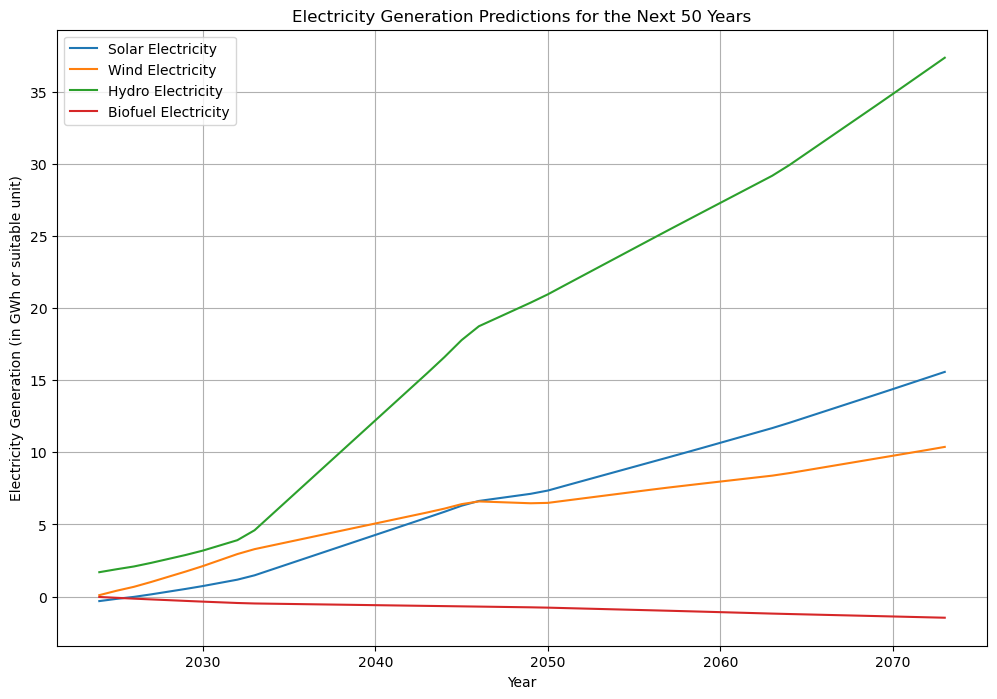

In [30]:
# 5. Visualization of the predictions
plt.figure(figsize=(12, 8))

# Plot each output variable
plt.plot(future_predictions['year'], future_predictions['solar_electricity'], label='Solar Electricity')
plt.plot(future_predictions['year'], future_predictions['wind_electricity'], label='Wind Electricity')
plt.plot(future_predictions['year'], future_predictions['hydro_electricity'], label='Hydro Electricity')
plt.plot(future_predictions['year'], future_predictions['biofuel_electricity'], label='Biofuel Electricity')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Electricity Generation (in GWh or suitable unit)')
plt.title('Electricity Generation Predictions for the Next 50 Years')
plt.legend()
plt.grid(True)
plt.show()

- **Hydroelectric Energy:** Expected to see the most significant rise in the coming years.
- **Solar Energy:** Predicted to grow at a moderate rate.
- **Wind Energy:** Also forecasted to grow moderately.
- **Biofuel Energy:** Anticipated to decline steadily.

**Conclusion:** Over the next 50 years, renewable energy sources like hydroelectric, solar, and wind are set to increase, with hydroelectric energy leading the growth. In contrast, biofuel generation is expected to decrease, highlighting a shift towards more sustainable energy sources.


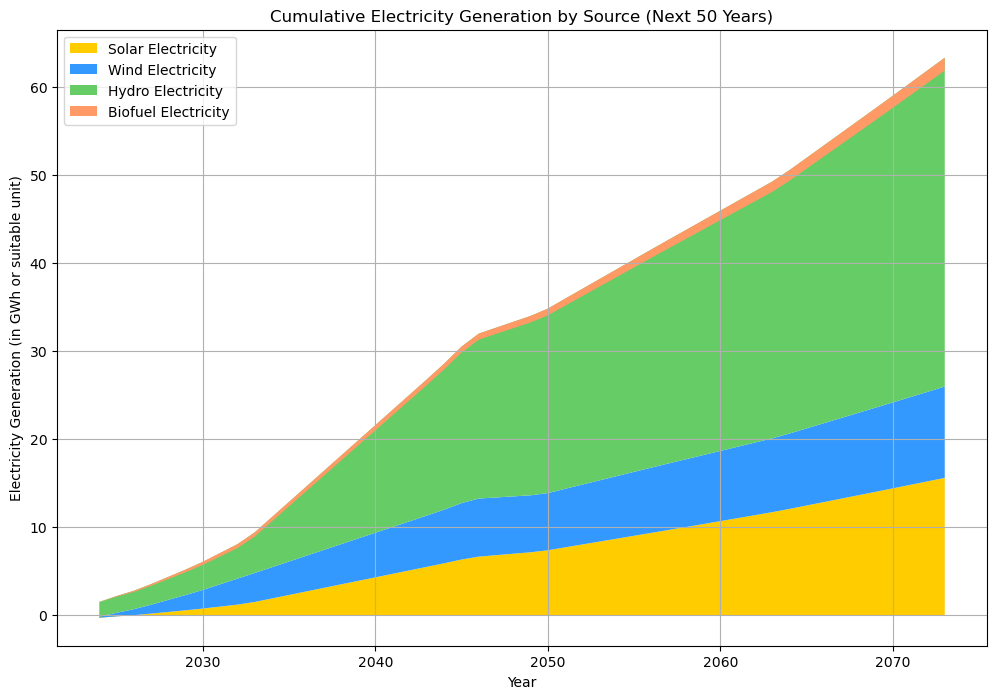

In [31]:
# 1. Stacked Area Plot for the next 50 years
plt.figure(figsize=(12, 8))

# Stack all predicted values
plt.stackplot(
    future_predictions['year'],
    future_predictions['solar_electricity'],
    future_predictions['wind_electricity'],
    future_predictions['hydro_electricity'],
    future_predictions['biofuel_electricity'],
    labels=['Solar Electricity', 'Wind Electricity', 'Hydro Electricity', 'Biofuel Electricity'],
    colors=['#ffcc00', '#3399ff', '#66cc66', '#ff9966']
)

# Labels and title
plt.xlabel('Year')
plt.ylabel('Electricity Generation (in GWh or suitable unit)')
plt.title('Cumulative Electricity Generation by Source (Next 50 Years)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


- **Growth of Solar and Wind:** Significant growth in cumulative electricity generation over the next 50 years.
- **Consistent Increase in Hydroelectricity:** Expected to see a consistent rise over the years, surpassing solar and wind.
- **Decline in Biofuel:** Predicted to decrease steadily.

**Conclusion:** The graph suggests a promising future for renewable energy, with hydroelectric energy leading the growth. Solar and wind will also see significant increases, while biofuel generation is expected to decline. Successful integration will require policy support and technological advancements.

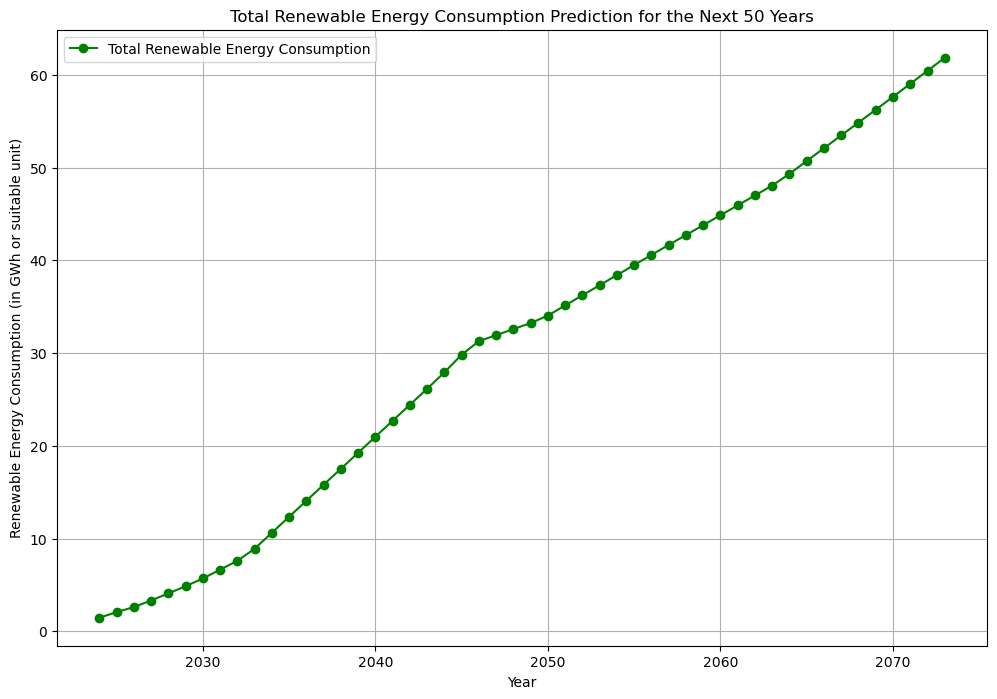

In [38]:
# 2. Total Renewable Energy Consumption Prediction for the next 50 years
plt.figure(figsize=(12, 8))

# Correct calculation: total renewable energy consumption (solar + wind + hydro + biofuel)
future_predictions['total_renewable_consumption'] = (
    future_predictions['solar_electricity'] +
    future_predictions['wind_electricity'] +
    future_predictions['hydro_electricity'] +
    future_predictions['biofuel_electricity']
)

# Plot the total renewable energy consumption
plt.plot(future_predictions['year'], future_predictions['total_renewable_consumption'], label='Total Renewable Energy Consumption', color='green', marker='o')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Renewable Energy Consumption (in GWh or suitable unit)')
plt.title('Total Renewable Energy Consumption Prediction for the Next 50 Years')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Analysis of Renewable Energy Consumption Graph

**The graph indicates a positive trend toward increasing renewable energy consumption over the next 50 years.** This reflects a growing commitment to cleaner and sustainable energy sources.

**Key Conclusions:**

- **Sustained Growth:** Renewable energy consumption is expected to grow continuously, indicating significant investment in technologies.
- **Decarbonization Efforts:** The upward trend shows an ongoing shift away from fossil fuels.
- **Exceeding Estimates:** Actual consumption may surpass projections due to advancements and policy support.

**Implications:**

- **Energy Transition:** A significant shift toward renewables is underway, necessitating supportive government policies and infrastructure development.
- **Technological Innovation:** Improvements in efficiency and storage are crucial for sustaining growth.
  
**Challenges:**

- **Intermittency and Infrastructure:** The variability of renewable sources requires advanced management systems and infrastructure investments.
- **Equity in Transition:** Ensuring equitable benefits during the energy transition is essential.


---

---

## 9. Visualizations

### Comprehensive Model Evaluation Visualizations

This section presents a series of five visualizations that facilitate the evaluation of the model's performance. The plots include:

1. **Comparison of Actual vs. Predicted Values for Output Variables in Deep Learning**: A general overview of how well the model's predictions align with actual values across different output variables.

2. **Actual vs. Predicted Electricity Demand**: A scatter plot that compares the actual electricity demand with the predicted values from the model, helping to assess the accuracy of the predictions.
  
3. **Predictions vs. Actual Values for Energy Consumption**: A line plot illustrating the relationship between predicted energy consumption and actual measurements, allowing for a detailed comparison over samples.
  
4. **Residuals vs. Predicted Values**: A scatter plot of residuals (errors) against predicted values, which helps identify any patterns indicating model biases or areas for improvement.

5. **Learning Curve**: Graphs illustrating how training and test scores change with varying training sizes, providing insights into the model's learning behavior and potential overfitting or underfitting issues.




### Comparison of Actual vs. Predicted Values for Output Variables in deep learning (Time Series)

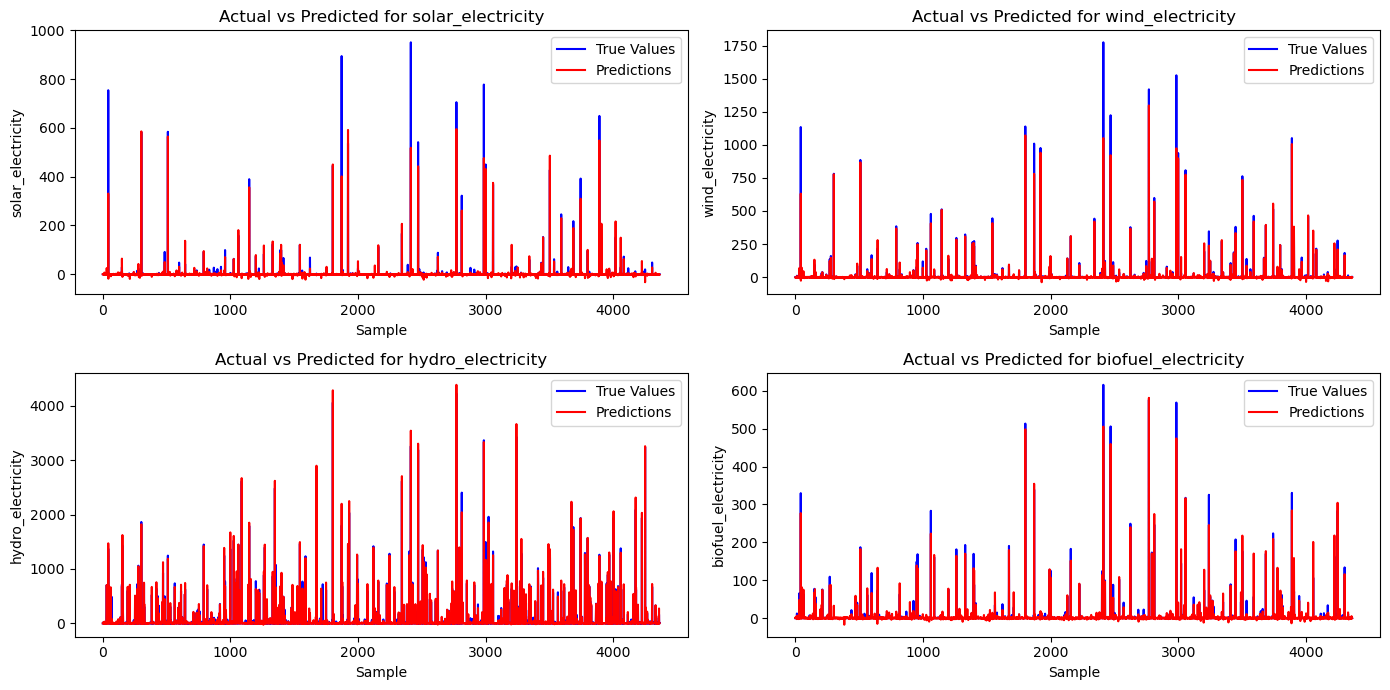

In [21]:

plt.figure(figsize=(14, 7))

# Plot for each output variable
for i, column in enumerate(y.columns):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[column].values, label='True Values', color='blue')
    plt.plot(dl_predictions[:, i], label='Predictions', color='red')
    plt.title(f'Actual vs Predicted for {column}')
    plt.xlabel('Sample')
    plt.ylabel(column)
    plt.legend()

plt.tight_layout()
plt.show()

### Relevant Analysis of Energy Generation Prediction Graphs

**General Interpretation:**

- **Good overall fit:** The model's predictions (red line) are close to the actual values (blue line) for most cases.
- **Variability in accuracy:** Some discrepancies, especially at peak times, suggest the model struggles with high-precision predictions during these periods.
- **Seasonal patterns:** Evident in solar and wind generation, reflecting their dependence on weather conditions.

**Source-Specific Analysis:**

- **Solar:** Captures daily and seasonal patterns well, but some peaks are less accurate.
- **Wind:** More challenging due to variability; general trend captured, but significant deviations occur.
- **Hydroelectric:** Less seasonal variation; general trend well captured, but some peaks are less accurate.
- **Biofuel:** Less variability; general trend captured accurately.

**Possible Reasons for Discrepancies:**

- **Data complexity:** Influenced by multiple factors like weather, demand, and resource availability.
- **Model limitations:** Struggles to capture all data complexities.
- **Data quality:** Affects prediction accuracy.
- **Extreme events:** Difficult to predict.

**Conclusions:**

> The model predicts energy generation with reasonable accuracy but needs improvement for peak and extreme event predictions.

### Actual vs Predicted Electricity Demand

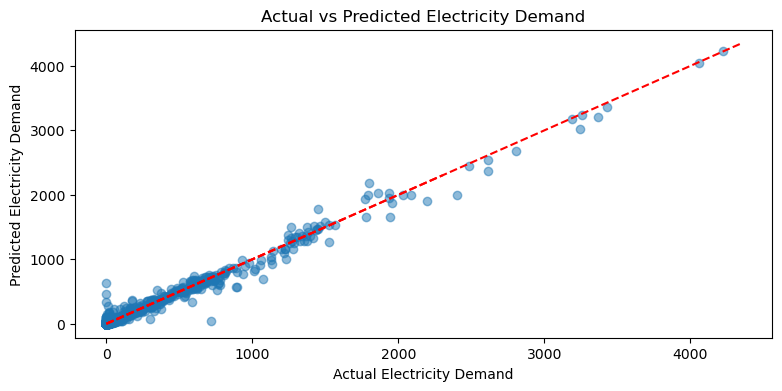

In [22]:
# Create a figure for the scatter plot with specified dimensions
plt.figure(figsize=(9, 4))

# Scatter plot showing actual vs predicted electricity demand with some transparency
plt.scatter(y_test, y_pred_rf, alpha=0.5)

# Plot a reference line for perfect predictions (y = x) using a dashed red line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')

# Label for the x-axis representing actual electricity demand
plt.xlabel('Actual Electricity Demand')

# Label for the y-axis representing predicted electricity demand
plt.ylabel('Predicted Electricity Demand')

# Title for the plot to indicate the content being visualized
plt.title('Actual vs Predicted Electricity Demand')

# Display the plot
plt.show()

### Analysis of Actual vs. Predicted Electricity Demand Graph

- **Each point**: Represents a pair of values - actual electricity demand and the model's predicted demand at the same time.
- **Red diagonal line**: Ideal scenario where predictions perfectly match actual values. Points on this line indicate no prediction error.
- **Blue points**: Individual model predictions. Their spread around the diagonal line indicates prediction accuracy.

**Graph Interpretation**:

- **General trend**: Points align along an ascending diagonal, suggesting the model captures the overall trend of electricity demand. As actual demand increases, predictions also increase.
- **Accuracy**: Points are not perfectly on the diagonal line, indicating some prediction error. However, the spread is not excessive, suggesting reasonable accuracy.
- **Biases**: No systematic bias observed. Points do not consistently fall above or below the diagonal line, indicating the model neither consistently underestimates nor overestimates demand.

**Conclusions:**

> The model provides a solid foundation for predicting electricity demand, but further research is needed to address the limitations and enhance its predictive capabilities.


### Predictions vs Actual Values for Energy Consumption


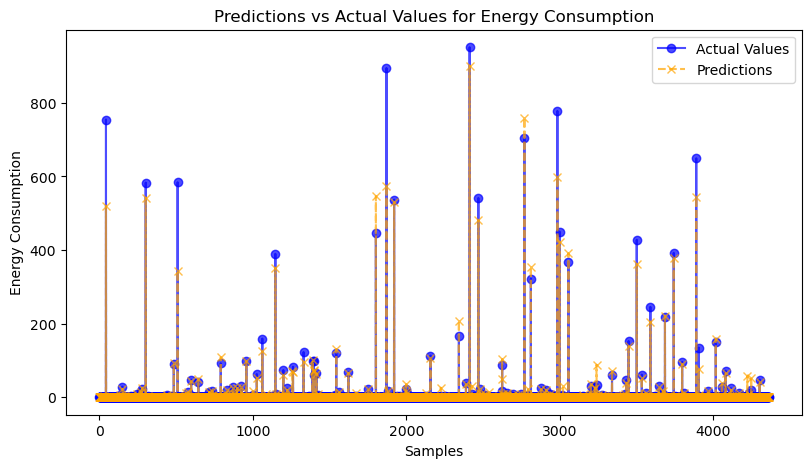

In [23]:
# Set the index for the output variable to be visualized
output_index = 0

# Create a figure for the line plot with specified dimensions
plt.figure(figsize=(9.5, 5))

# Plot actual values using blue circles, with some transparency
plt.plot(y_test.values[:, output_index], label='Actual Values', marker='o', color='blue', linestyle='-', alpha=0.7)

# Plot predicted values using orange crosses, with a dashed line style
plt.plot(y_pred_rf[:, output_index], label='Predictions', marker='x', color='orange', linestyle='--', alpha=0.7)

# Title for the plot indicating the context of energy consumption predictions vs actual values
plt.title('Predictions vs Actual Values for Energy Consumption')

# Label for the x-axis representing the sample indices
plt.xlabel('Samples')

# Label for the y-axis representing energy consumption values
plt.ylabel('Energy Consumption')

# Add a legend to differentiate between actual values and predictions
plt.legend()

# Display the plot
plt.show()


### Analysis of Predictions vs. Actual Energy Consumption

**What does the graph show?**

- **Actual energy consumption**: Blue line with dots
- **Model's predicted values**: Orange line with "x" marks
- **X-axis**: Represents time points
- **Y-axis**: Indicates the amount of energy consumed

**General Interpretation:**

- **Good overall trend capture:** The model generally follows the trend of actual energy consumption, with predictions increasing as actual consumption increases.
- **Systematic underestimation:** The model tends to underestimate energy consumption, especially at peaks, as the orange line is often below the blue line.
- **Seasonal patterns:** The model captures some seasonal or cyclical patterns, though not perfectly.

**Conclusions:**

> The model shows a reasonable trend capture but needs improvement in accuracy, especially for peak predictions. I need to consider exploring different models, adding more relevant variables, tuning hyperparameters, and ensuring high-quality data for better performance.


### Residuals vs Predicted Values

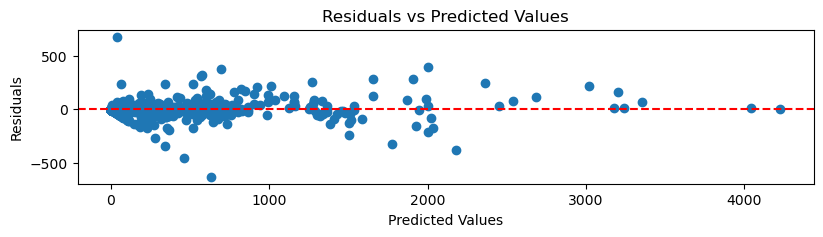

In [24]:
# Calculate the residuals by subtracting predicted values from actual values
residuals = y_test - y_pred_rf

# Create a figure for the residual plot with specified dimensions
plt.figure(figsize=(9.5, 2))

# Scatter plot showing the residuals against the predicted values
plt.scatter(y_pred_rf, residuals)

# Add a horizontal line at y=0 to indicate no error (perfect prediction)
plt.axhline(0, color='red', linestyle='--')

# Title for the plot indicating the comparison of residuals and predicted values
plt.title('Residuals vs Predicted Values')

# Label for the x-axis representing predicted values
plt.xlabel('Predicted Values')

# Label for the y-axis representing residuals (errors)
plt.ylabel('Residuals')

# Display the plot
plt.show()


### Analysis of Residuals vs. Predicted Values Graph

**What does the graph show?**

- **Residual Distribution**: Points are randomly distributed around the horizontal red line (zero residual), indicating no systematic bias in predictions.
- **Homocedasticity**: The spread of points is relatively constant across the range of predicted values, suggesting consistent error variance.
- **No Clear Patterns**: Absence of funnel shapes or curves in the residuals, indicating the model captures most data variations well.
- **Outliers**: Some points deviate significantly, indicating areas where the model struggles with precise predictions.

**Conclusions**:

> - The model performs reasonably well, with random residual distribution and no evident patterns.
> - Presence of outliers suggests room for improvement in prediction accuracy.

### Learning Curve Visualization

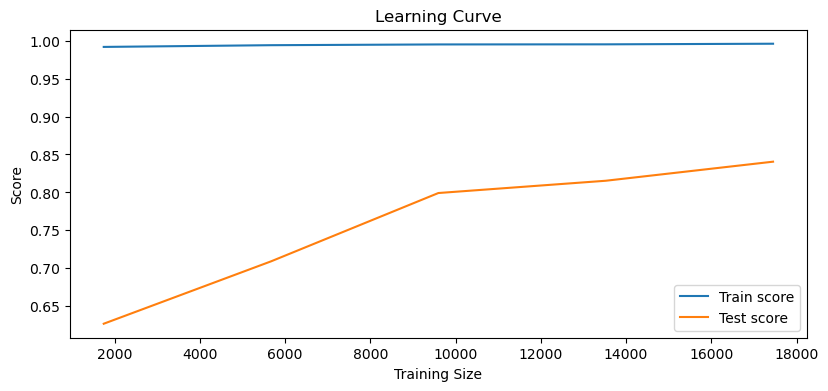

In [25]:
# Compute learning curves by training the model with different sizes of training data
train_sizes, train_scores, test_scores = learning_curve(best_rf_model, X, y, cv=5)

# Calculate the mean training scores across all cross-validation folds
train_mean = train_scores.mean(axis=1)

# Calculate the mean testing scores across all cross-validation folds
test_mean = test_scores.mean(axis=1)

# Create a figure for the learning curve with specified dimensions
plt.figure(figsize=(9.5, 4))

# Plot the mean training scores against the training sizes
plt.plot(train_sizes, train_mean, label='Train score')

# Plot the mean test scores against the training sizes
plt.plot(train_sizes, test_mean, label='Test score')

# Title for the plot indicating it represents a learning curve
plt.title('Learning Curve')

# Label for the x-axis representing the sizes of the training set
plt.xlabel('Training Size')

# Label for the y-axis representing the performance score of the model
plt.ylabel('Score')

# Add a legend to differentiate between training and testing scores
plt.legend()

# Display the plot
plt.show()


### Learning Curve Analysis

**Graph Description**:
- **X-axis**: Training set size
- **Y-axis**: Evaluation metric (likely accuracy)
- **Lines**:
  - **Blue**: Training set score
  - **Orange**: Test set score

**Results Interpretation**:
1. **Overfitting**: The blue line quickly reaches a high value and remains constant, indicating the model is learning specific patterns, including noise.
2. **Underfitting**: The orange line gradually increases but stabilizes at a low value, suggesting the model isn't complex enough to capture underlying data relationships.
3. **Gap Between Curves**: A significant gap indicates overfitting, with the model memorizing training data rather than generalizing.

**Conclusions**:

> The learning curve indicates the model is overfitted to the training data. Implementing strategies to reduce model complexity and enhance generalization is necessary for better performance.

---

## 10. Final Conclusions

In this project, both the **Random Forest/GridSearchCV (Machine Learning)** and **Multi-Layer Perceptron for Multivariate Time Series Forecasting (Deep Learning)** models demonstrated their effectiveness in predicting renewable energy generation.

### Performance Overview
- **Random Forest Model**: This model exhibited notable strengths, particularly in training speed and prediction accuracy. Its capability to handle high-dimensional data and capture complex interactions among features resulted in low error rates, establishing it as a reliable choice for this analysis. However, indications of overfitting were observed, which can be addressed through careful tuning of parameters such as `max_depth`, `min_samples_split`, and `min_samples_leaf`.
- **Time Series Model**: Although slightly slower in training, this model also delivered satisfactory results. Neural networks are adept at modeling intricate relationships within data, and this project underscored their potential in energy predictions. There remains ample opportunity for further optimization, particularly through hyperparameter tuning and experimentation with diverse architectures.

### Final Conclusions on Renewable Energy Forecasting
The analysis predicts a promising outlook for renewable energy sources over the next 50 years. Hydroelectric energy is expected to lead in growth, followed by significant increases in solar and wind energy. Conversely, biofuel generation is anticipated to decline steadily. This trend reflects a broader commitment to cleaner and more sustainable energy solutions as the transition away from fossil fuels progresses. To actualize this potential, it is crucial to implement supportive government policies, foster technological advancements in efficiency and storage, and invest in infrastructure, all while ensuring equitable benefits during the energy transition.

### Future Directions
Looking ahead, my goal is to advance this work by developing an **Artificial Intelligence** system capable of managing larger datasets through **Deep Learning** techniques. This AI will not only provide predictions but also facilitate interactive communication, empowering users to discuss energy-related challenges and propose actionable solutions for a more sustainable future.
To augment the capabilities of this AI, I plan to integrate **APIs** that deliver real-time data feeds, allowing the system to continuously update and refine its understanding of energy dynamics. By leveraging these data streams, the AI will be positioned to analyze trends, identify inefficiencies, and recommend improvements, ultimately contributing to the creation of smarter energy management solutions.

### Summary
While the current models have performed admirably, addressing overfitting in the Random Forest model and optimizing the deep learning model are key steps for enhancement. This vision of a conversational, data-driven AI specialized in energy solutions presents an exciting avenue for future exploration.



---

## 11. Acknowledgements

I would like to express my heartfelt gratitude to **Ironhack Bootcamp** for all the invaluable knowledge and skills I've acquired throughout this journey. The experience has not only been educational but also incredibly enriching on a personal level. 

A special thanks to my amazing mentors, **Santiago, Antonio,** and **Nicolás**, whose guidance and support have been instrumental in my learning process. Your insights and encouragement have motivated me to push my limits and strive for excellence.

I also want to extend my appreciation to all my fellow classmates. Thank you for the countless moments of laughter, collaboration, and hard work we shared together. These memories will stay with me as a testament to our collective journey. 

*Thank you all for being a part of this transformative experience!*


*Carlos Vergara Gámez*

---